# <center>Common pitfalls in the interpretation of coefficients of linear models<center>

## The dataset: wages

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_openml

# as_frame=True ：将数据转为Pandas的DF类型
survey = fetch_openml(data_id=534, as_frame=True)

X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [8]:
# 注意，数据集包含分类变量和数值变量。之后在对数据集进行预处理时，我们需要考虑到这一点
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [9]:
# 我们的预测目标:工资。工资被描述为每小时美元的浮点数
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

首先，让我们通过观察变量分布以及它们之间的成对关系来获得一些见解。只使用数值变量。在下面的图中，每个点代表一个样本。

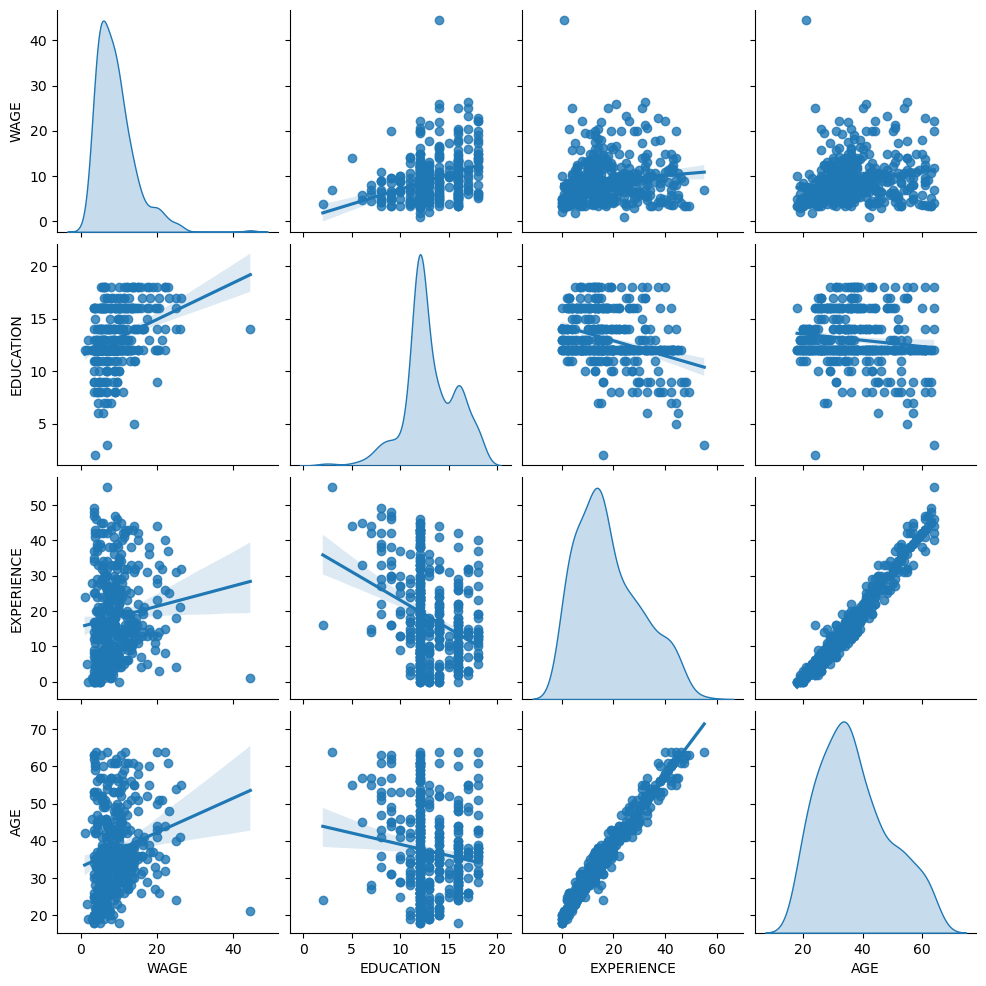

In [18]:
train_dataset = X_train.copy()
# print(train_dataset)
train_dataset.insert(0, "WAGE", y_train)

# kind='reg'：加回归线(默认值是scatter)， diag_kind：对角线绘制方式(hist/kde/None)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

## The machine-learning pipeline

To design our machine-learning pipeline, we first manually check the type of data that we are dealing with：

In [19]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


如前所述，数据集包含不同数据类型的列，我们需要对每种数据类型应用特定的预处理。特别地，如果分类变量不先被编码为整数，则不能包含在线性模型中。此外，为了避免类别型特征被视为有序值，我们需要对它们进行独热编码。我们的预处理器会：
* 独热编码(即按类别生成列)分类列，仅适用于非二元分类变量;
* 作为第一种方法(我们将在后面看到数值归一化如何影响我们的讨论)，保持数值原样。

In [21]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

To describe the dataset as a linear model we use a ridge regressor with a very small regularization and to model the logarithm of the WAGE.

为了将数据集描述为线性模型，我们使用具有非常小正则化的岭回归器，并对工资的对数进行建模。

In [22]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

## Processing the dataset

In [23]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [24]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

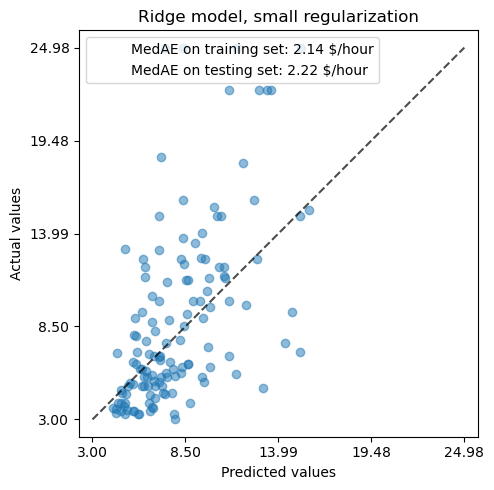

In [34]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
# 固定布局,防止因为拉伸布局而使得lable重叠起来
plt.tight_layout()
# plt.show()

学习到的模型远远不是一个做出准确预测的好模型:当看上面的图时，这是很明显的，良好的预测应该位于黑色虚线上。

在下一节中，我们将解释模型的系数。虽然我们这样做，但我们应该记住，我们得出的任何结论都是关于我们构建的模型，而不是关于数据的真实(现实世界)生成过程。

## Interpreting coefficients: scale matters

First of all, we can take a look to the values of the coefficients of the regressor we have fitted.

首先，我们可以看看我们拟合的回归器的系数值。

In [35]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
RACE_Hispanic,-0.013527
RACE_Other,-0.009084
RACE_White,0.022586
OCCUPATION_Clerical,0.000063
OCCUPATION_Management,0.090545
OCCUPATION_Other,-0.025084
OCCUPATION_Professional,0.071981
OCCUPATION_Sales,-0.046619
OCCUPATION_Service,-0.091036
SECTOR_Construction,-0.000159


年龄系数表示为“美元/小时每生命年”，教育系数表示为“美元/小时每教育年”。系数的这种表示有利于明确模型的实际预测:年龄增加1年意味着减少0.030867美元/小时，而教育增加1年意味着增加0.054699美元/小时。另一方面，分类变量(如联合变量或性别变量)是一个维度上的数值，取值为0或1。它们的系数以美元/小时表示。然后，我们无法比较不同系数的大小，因为特征具有不同的自然尺度，因此由于它们的度量单位不同，因此值范围也不同。如果我们绘制系数，这一点会更明显。

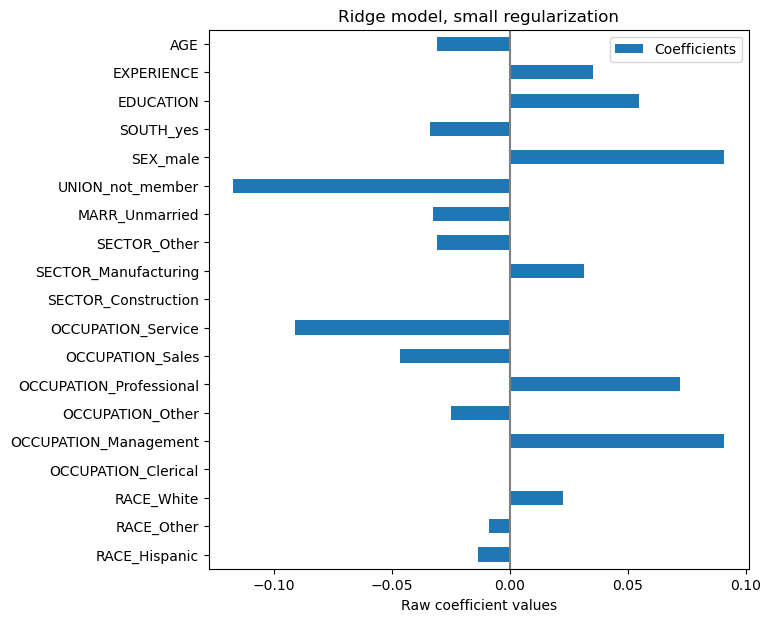

In [36]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

事实上，从上图来看，决定工资的最重要因素似乎是变量UNION，即使我们的直觉可能告诉我们，EXPERIENCE 等变量应该有更大的影响。

通过系数图来衡量特征重要性可能会产生误导，因为其中一些特征在小范围内变化很大，而其他特征(如AGE)的变化很大，可能长达几十年。

如果我们比较不同特征的标准差，这是显而易见的。

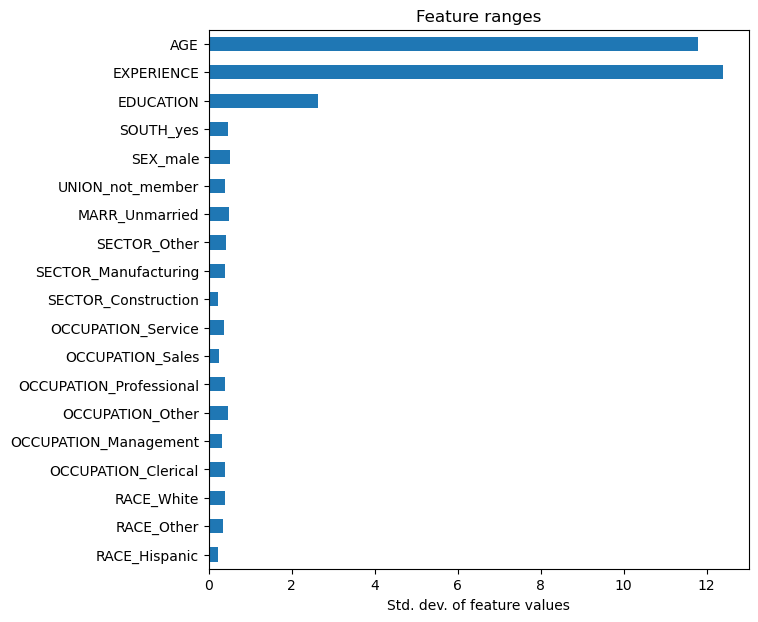

In [37]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

将这些系数乘以相关特征的标准差，可以将所有系数缩减到同一度量单位。正如我们之后将看到的，这等价于将数值变量归一化为其标准差

通过这种方式，我们强调，在其他条件相同的情况下，特征的方差越大，输出上相应系数的权重就越大。

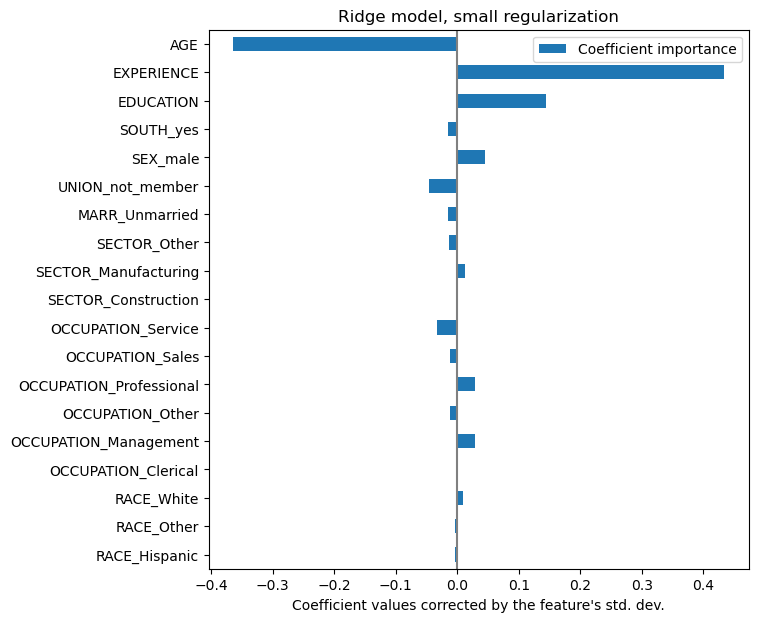

In [38]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

现在系数已经缩放，我们可以安全地比较它们了。

> 提醒:为什么上面的图表明年龄的增加会导致工资的减少?为什么初始的成对图告诉我们相反的信息?


上面的图告诉我们当所有其他特征保持不变时，特定功能和目标之间的依赖关系，即条件依赖关系。当所有其他特征保持不变时，年龄的增加将导致工资的减少。相反，当所有其他特征保持不变时，经验的增加将导致工资的增加。此外，年龄、经验和教育是对模型影响最大的三个变量。

## Checking the variability of the coefficients

我们可以通过交叉验证来检查系数的可变性:这是一种数据扰动(与重采样有关)。

如果系数在改变输入数据集时变化很大，则不能保证其坚固性，因此应该谨慎解释它们。

In [49]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    # n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

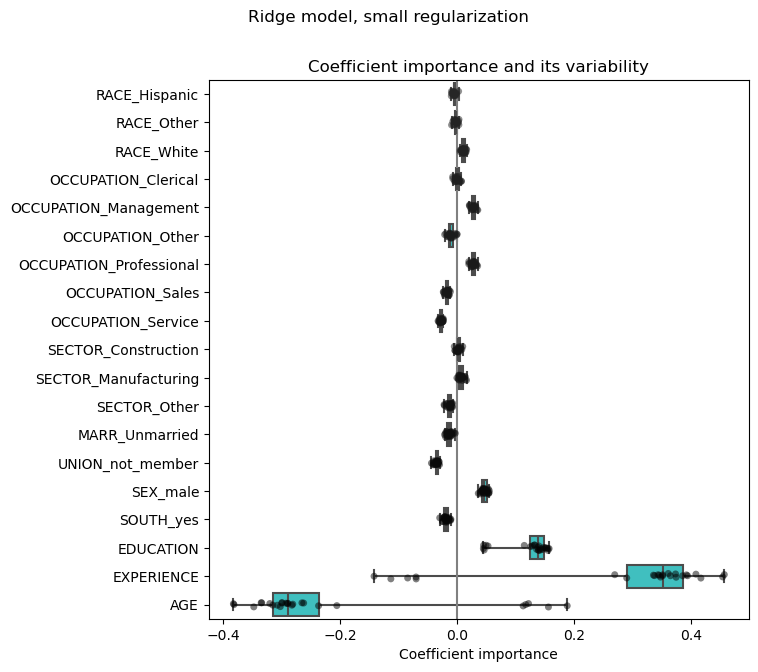

In [50]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)